In [19]:
''' Simulation of 2D Ising model. Tested on Python 3.10.6'''
'''Note that the graphs and fitting coeffitients seen here as an output may vary from those
you find in the official documentation of the project'''

'Note that the graphs and fitting coeffitients seen here as an output may vary from those\nyou find in the official documentation of the project'

## Introduction

Here I am going to present a project, simulating the 2D Ising model using Monte Carlo Simulation. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 500

The problem itself is defined on an $L = 10 \times 10 $grid, with a 100 spins pointing either up or down. The distribution of the spins on the grid is random, or all spins points upwards. I have defined a function, called __plotspins__, which visualize the grid

In [3]:
def plotspins(M,mode):
    plt.figure(figsize=(6,6))
    values = np.unique(M.ravel())
    
    im = plt.imshow(M, interpolation='none')
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="Spin {l}".format(l=values[i]) ) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    if(mode==1):
        plt.title('Randomozed sipns on grid')
    elif(mode==2):
        plt.title('Lattice after simulation')
    plt.grid(True)
    plt.xticks(ticks=np.linspace(0,9,10))
    plt.yticks(ticks=np.linspace(0,9,10))
    plt.show()

The lattice initialization happens here:

In [4]:

def initgrid(L = 10, allup=False, ifplot=True): #L: grid size, bool allup: All spins up? ifplot: to plot the lattice or not

    M=np.zeros([L,L]) #pre-allocation
    for i in range(len(M)):
        for j in range(len(M)):
            ran=np.random.random()
            if(ran<0.5):  
                M[i,j] = 1
            else:
                if allup==False: #means random spins
                    M[i,j] = -1
                else:
                    M[i,j] = 1
    if ifplot == True:
        plotspins(M,1)
    return M, L

To calculate __M/N__, the magnetisation, sum up all the spins and divide with the number of spins:

In [5]:
def calcMagnetization(M):
    spin = 0
    spin=np.sum(M)
    return spin/len(M)**2

I also wanted the model to stop after the quantities are not changing anymore relative to the average of the previous cycles. 

In [6]:
def earlystopping(array, delta, index):
    index=index+index % 30 # To ensure index%30=0.
    data=np.array(array[index-index/10:]) # data -> last 10pc of the index
    ave1=np.average(data) 
    data2=np.array(array[index-index/30:]) # data2 -> last 3 percent
    ave2=np.average(data2)
    if abs((ave2-ave1))<ave1/50: # Did the last 3pc of the data changed less than 2pc, relative to the last 10pc of the data?
        return True
    else:
        return False
    

The Hamiltonian for the Ising model is:
$$ H(\vec{\sigma}) = - J \sum_{<ij>} \sigma_i \sigma_j -h \sum_i \sigma_i$$ 
$J$ is the interaction strength and $h$ is the external magnetic field.<br>
Furthermore,
$$ P(\vec{\sigma}) = \dfrac{e^{-\beta H(\vec{\sigma})}}{Z} $$
where the partition function, Z is:
$$ Z = \sum_{ \{ \vec{\sigma} \} } e^{-\beta H(\vec{\sigma})}. $$

I also needed a function to calculate the energy change for a given spin-flip.
From theory, we know that for a single flip, the energy change is the following:
$$ \Delta E = 2 G(i,j) \cdot (h+J\cdot Sn). $$ 
Sn is the sum of the neighbouring terms, $G(i,j)$ is the selected spin

The transition probability is denoted by $W(i \rightarrow j)$. 
For the used Metropolis-Hastings algorithm the following form was considered:
$$ W(\sigma \rightarrow \sigma') = g(i\rightarrow j)\cdot A(i \rightarrow j) $$
In the case of the Monte Carlo method, the case the selection probability is uniform:
$$g(i \rightarrow j) = 1/N^2$$
 
Te second term respects the Metropolis-Hasting rule:
$$ A(i \rightarrow j) = 
\begin{cases} 
e^{ - \beta ( E_{j} - E_{i} ) } \ \ \ \ \ if \ E_{j} - E_{i}>0
\\
1 \hspace{2.5cm} otherwise
\end{cases} $$

So, imposing the detailed balanced condition:
$$ \dfrac{W(i\rightarrow j)}{W(j \rightarrow j)} = \dfrac{A(i \rightarrow j)}{A(j\rightarrow i)} = e^{ - \beta ( E_{j} - E_{i} ) }$$

In [7]:
def deltaE(spin, Sn, J, H):

  return 2 * spin * (H + J * Sn)

In [8]:
def isingmodel ( #actual simulation happens here
    n = 100,
    h = 1,
    K = 1, 
    kbT = 5,
    L = 10,
    M = np.zeros(10),
):
    
    Energy = 0 
    for i in range(L):
        for j in range (L):
            Sn = M[(i - 1) % L, j] + M[(i + 1) % L, j] + M[i, (j - 1) % L] + M[i, (j + 1) % L]   #For spin (i,j) the sum of the neighbouring terms, & ensuring the periodic boundary condition is fulfilled
            Energy -= M[i,j]*(h+K*Sn) #initial energy
    magnetization = []
    Energy=Energy/2 #every spin was counted twice (i,j); (j,i)
    energyHistory = []
    max=0
    
    for tstep in range(n):
        
        i=np.random.randint(10) #random selection
        j=np.random.randint(10)
        
        Sn = M[(i - 1) % L, j] + M[(i + 1) % L, j] + M[i, (j - 1) % L] + M[i, (j + 1) % L] #same as above
        
        dE= deltaE(M[i, j], Sn, K, h) #calculating deltaE
        
        if dE<0 or np.random.random()<np.exp(-dE/kbT): #Metropolis condition
            Energy+=dE # energy change
            M[i,j]=-1*M[i,j] #spin flip
            
        energyHistory.append(Energy) #logging
        magnetization.append(calcMagnetization(M))  #logging
        '''
        if tstep>100:
            if earlystopping(magnetization,0.1,tstep) == True:
                max=tstep
                break
    '''
    if max == 0: #Means that the eralystopping did not happen
        max=n 
    numofave=int(max/10) # for averaging the last 10% of the moves
    return energyHistory, np.average(np.array(energyHistory[max-numofave:])) ,M, max, magnetization, np.average(np.array(magnetization[max-numofave:])) 


        

Now that the model is defined, lets see an example.

Initialize Grid...


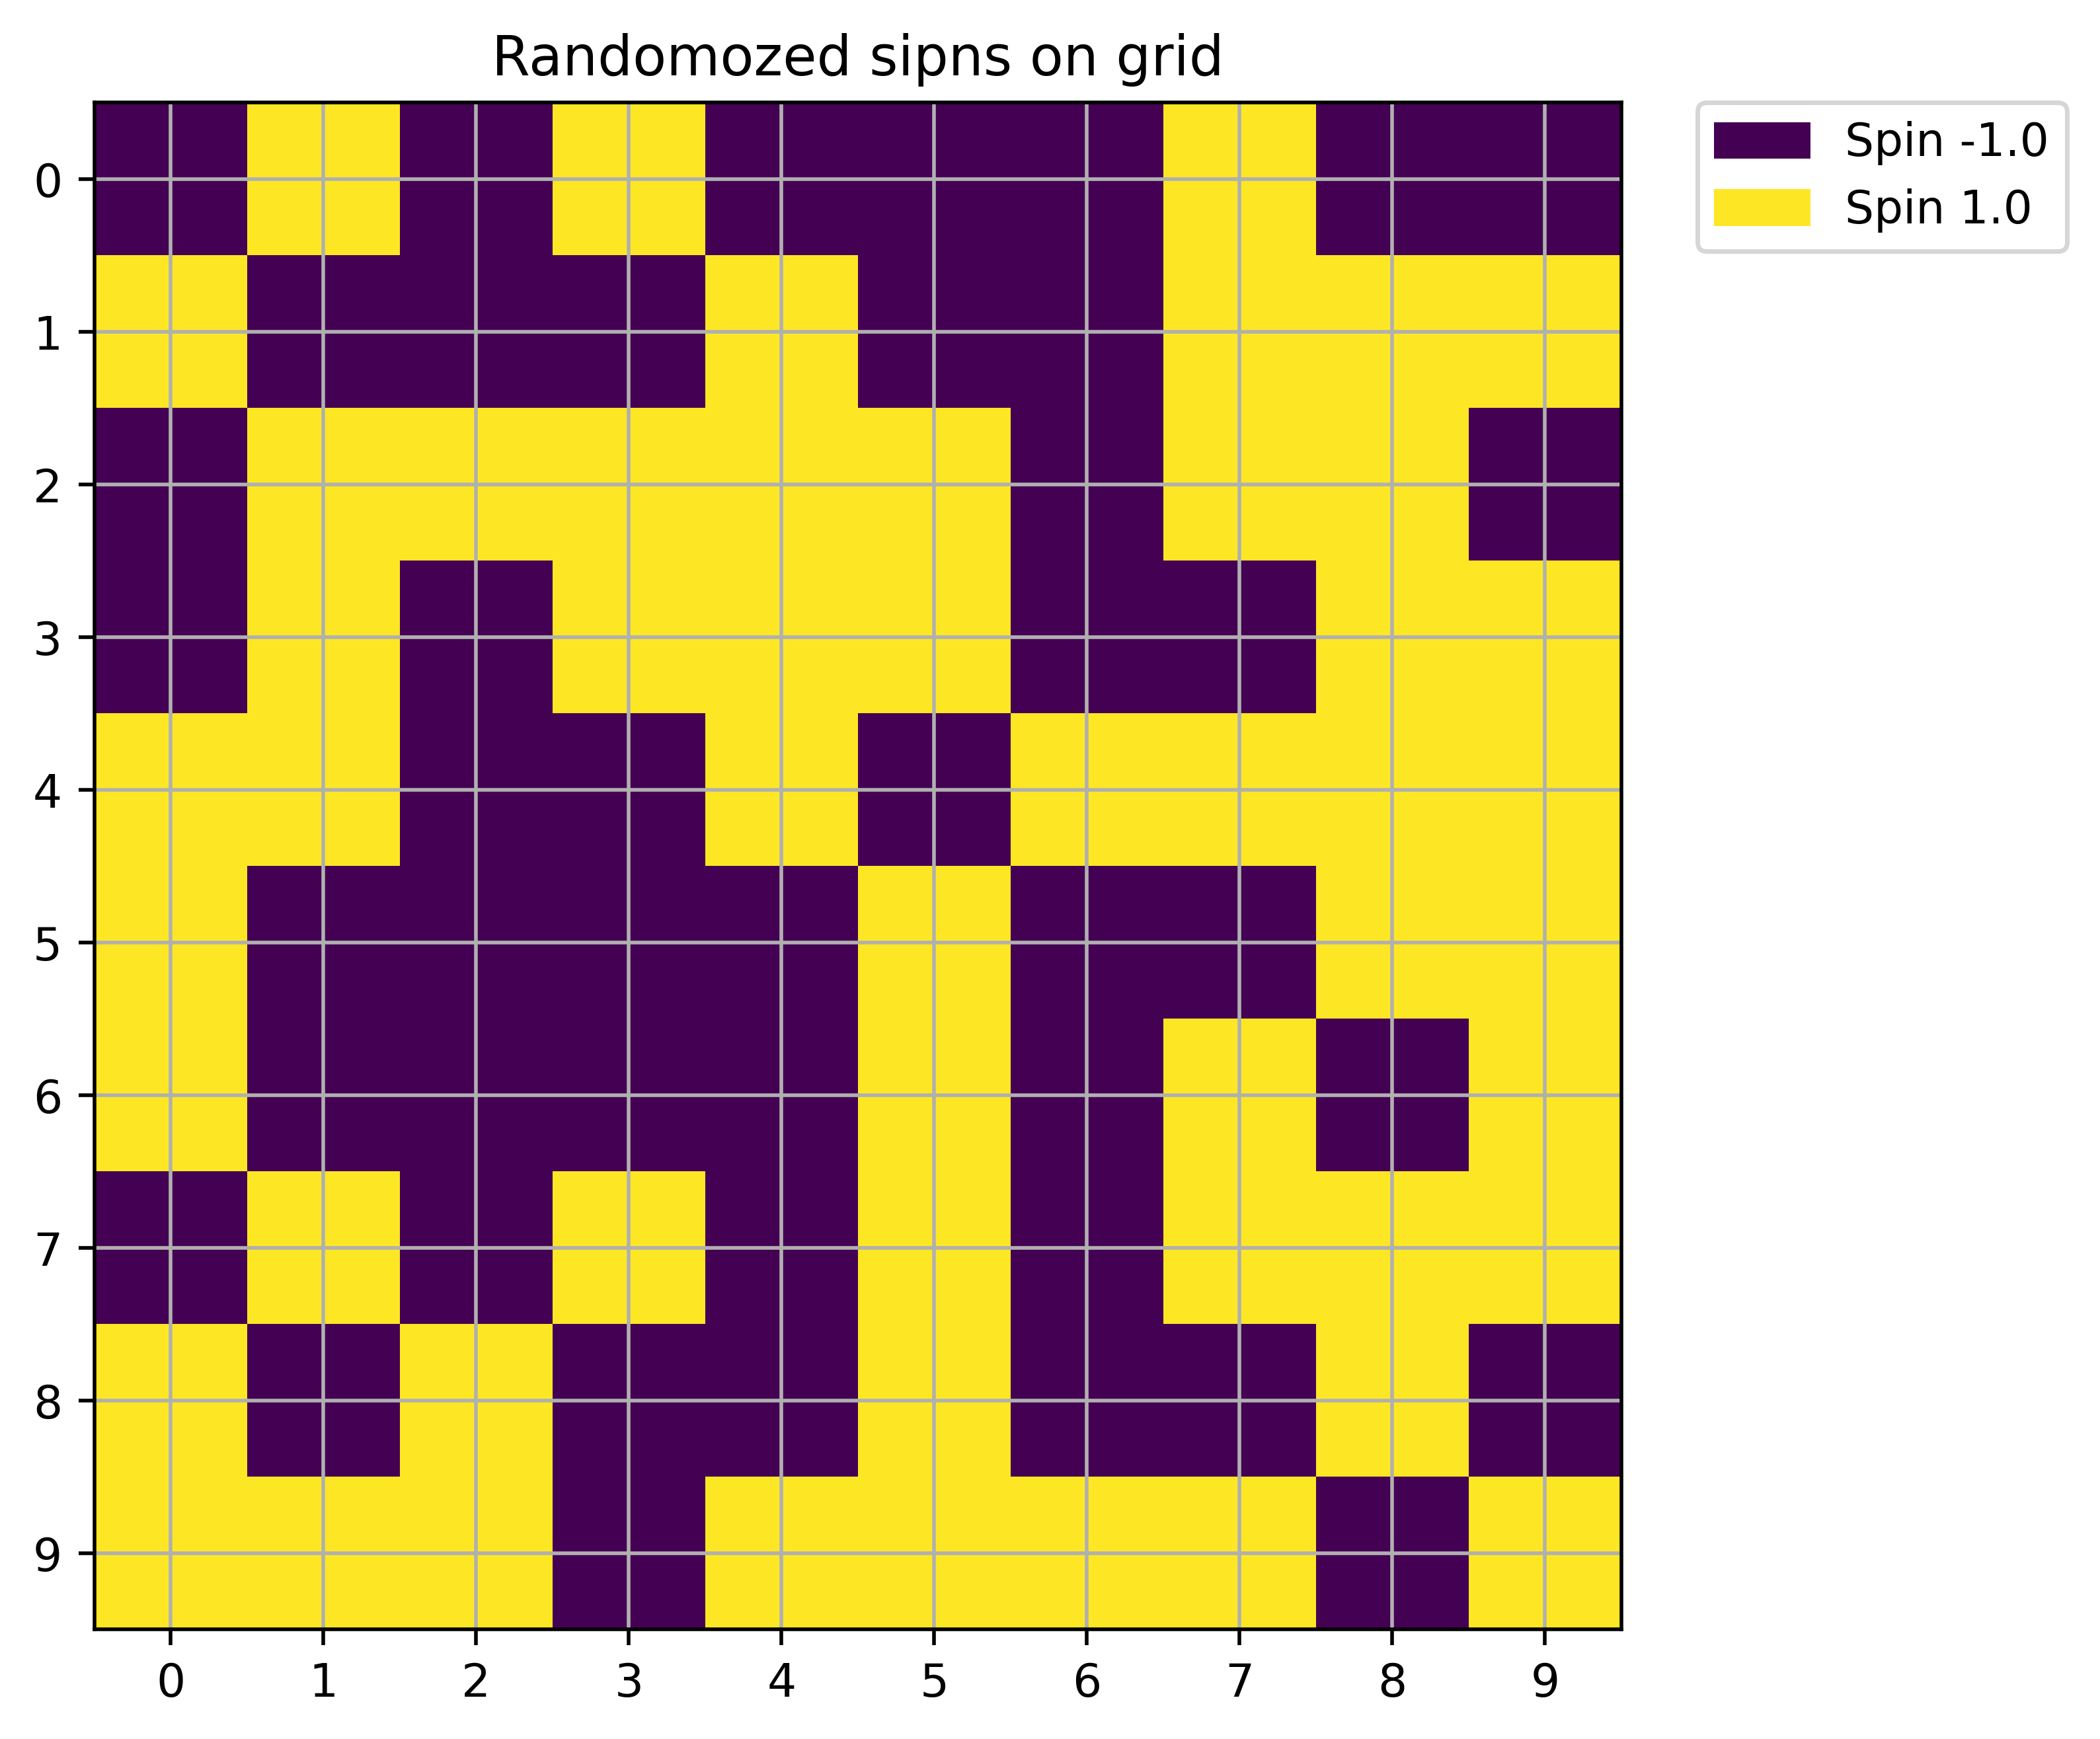

Grid initialized!
Start simulation...
Simulation successful!


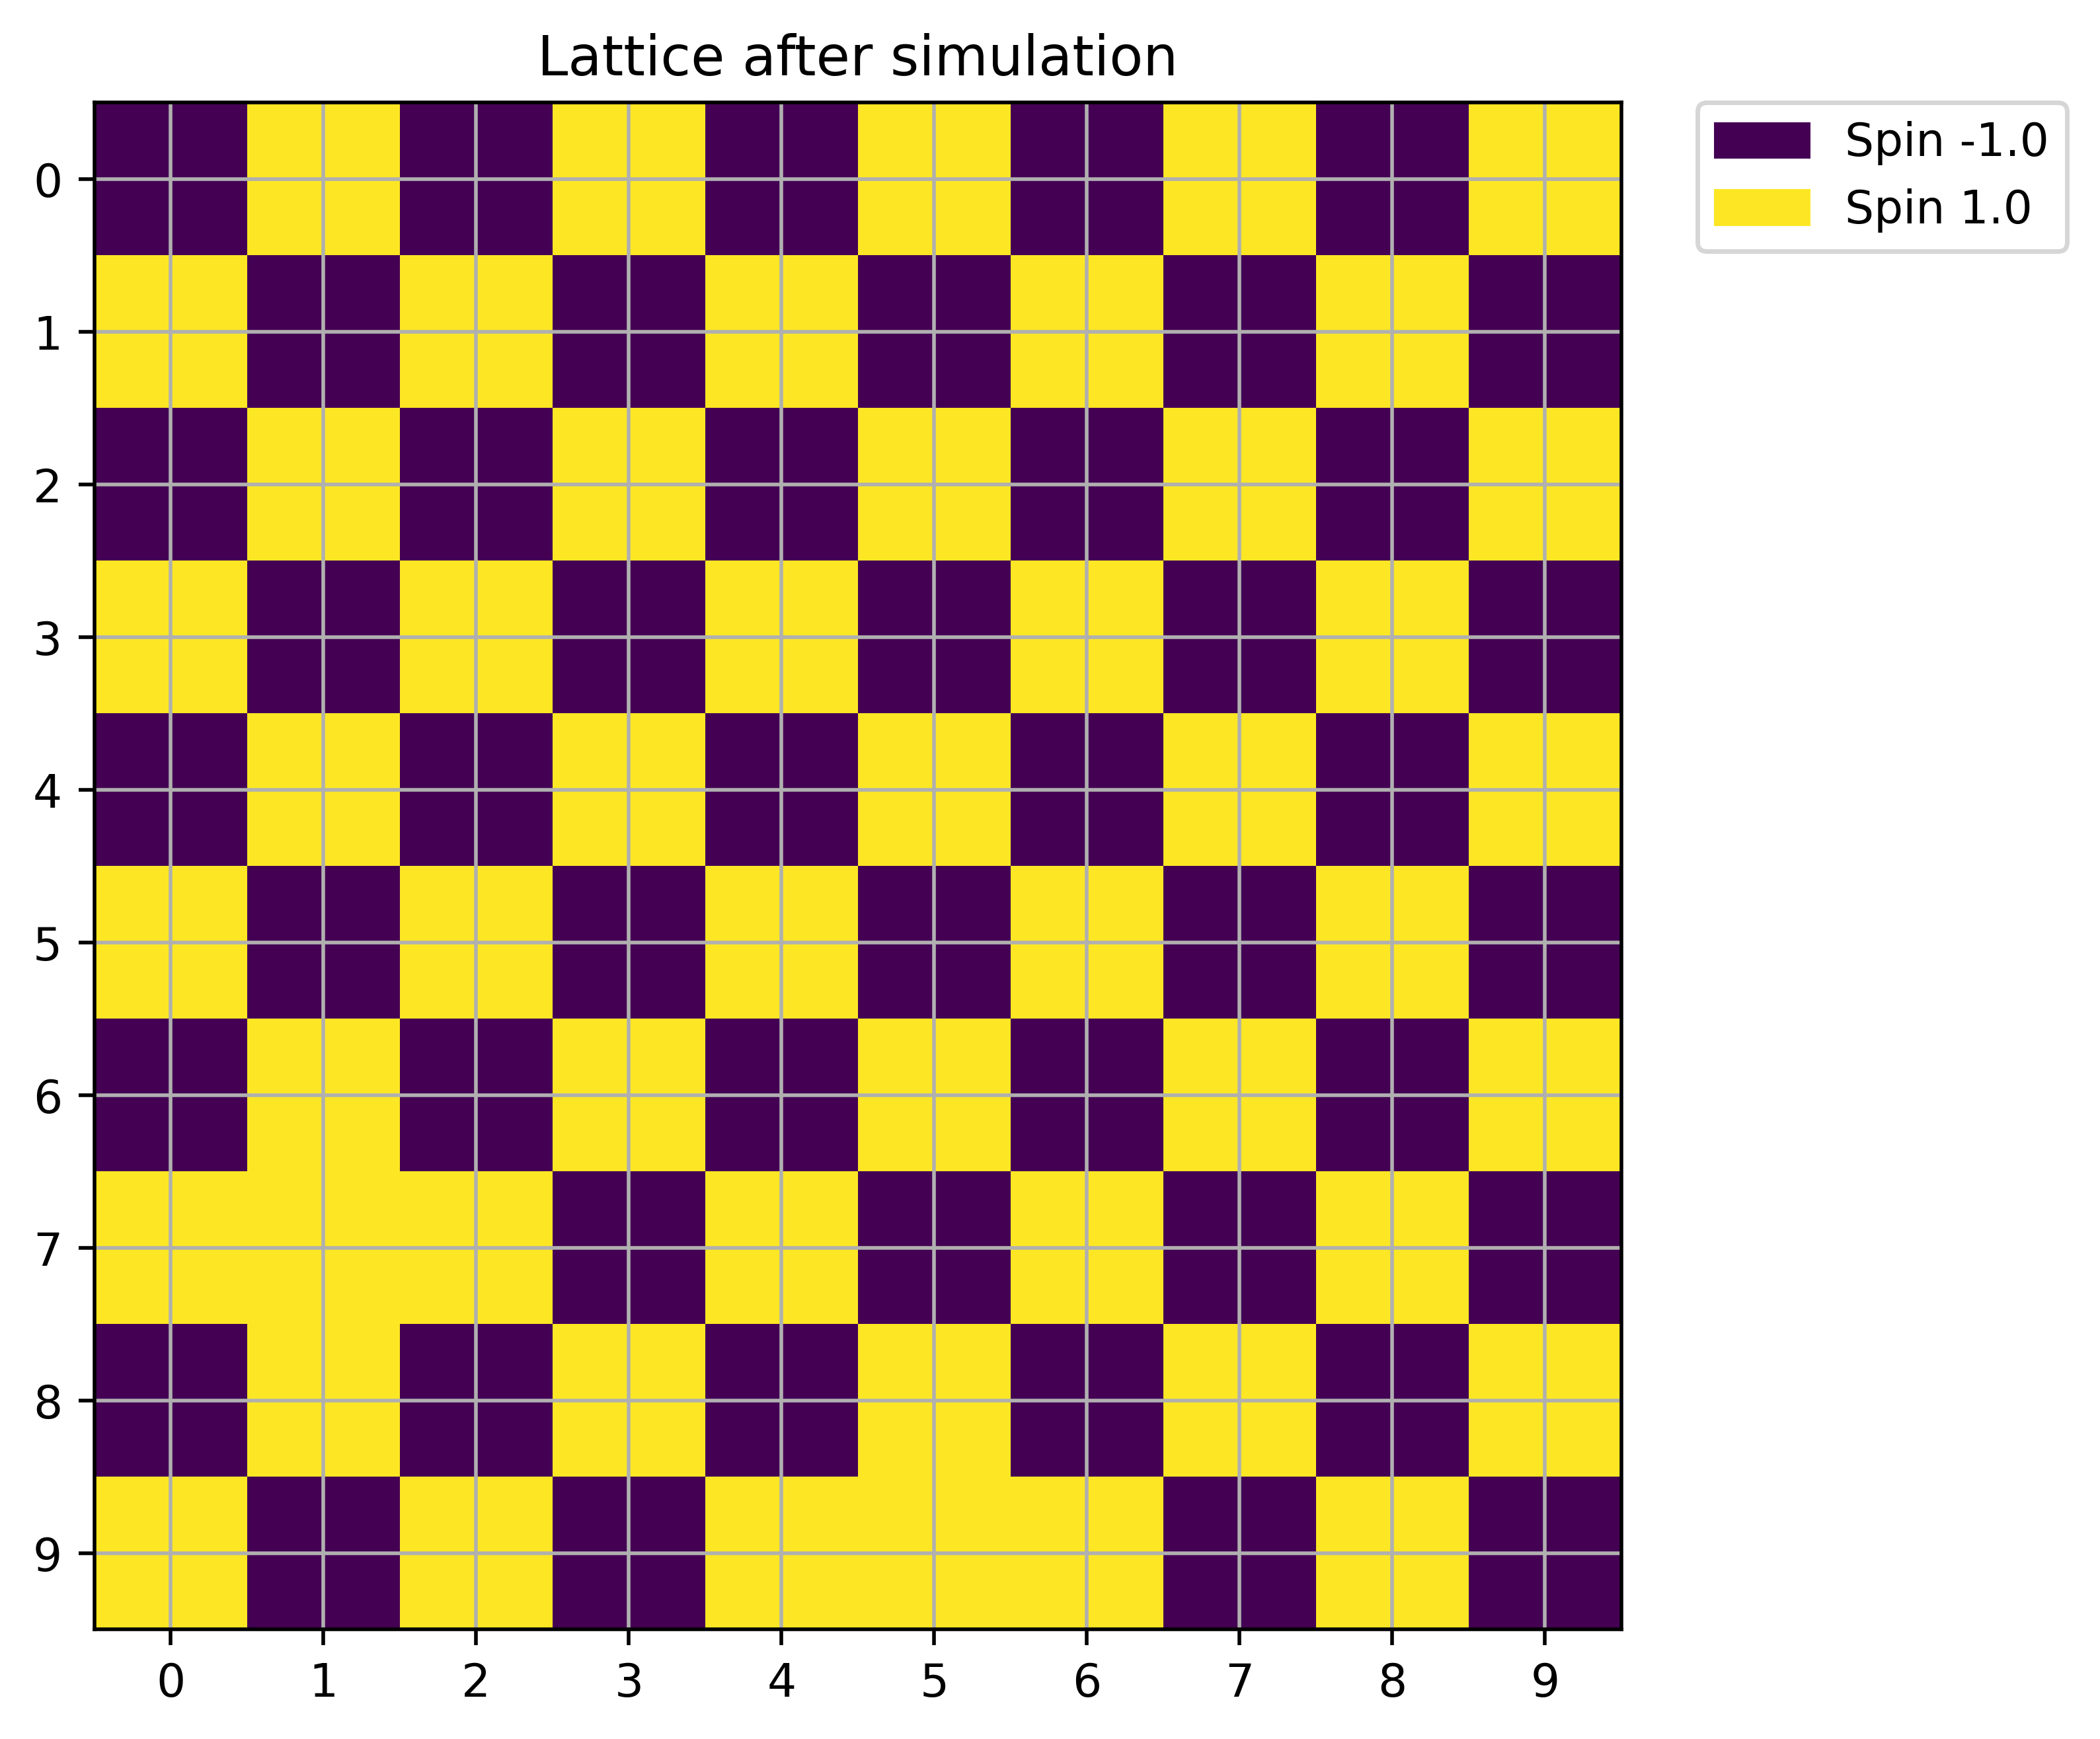

In [9]:
print('Initialize Grid...')
M, L = initgrid(10,False, True) # initgrid(size of grid, False = random spins true= all spins up, True=plot the spins on grid False= not to plot) -> returned: M= grid, L=size
print('Grid initialized!')
print('Start simulation...')
Earr, Eave, Spins, steps, Marr, Mave = isingmodel(1000000,2,-1,1,L,M) #isingmodel(number of max steps, external field h, interaction term, KbT, size, grid)
print('Simulation successful!')
plotspins(Spins,2) # plotspins(returned grid matrix called Spins, mode2= title: lattice after simulation) 


Visualize energy, magnetization:

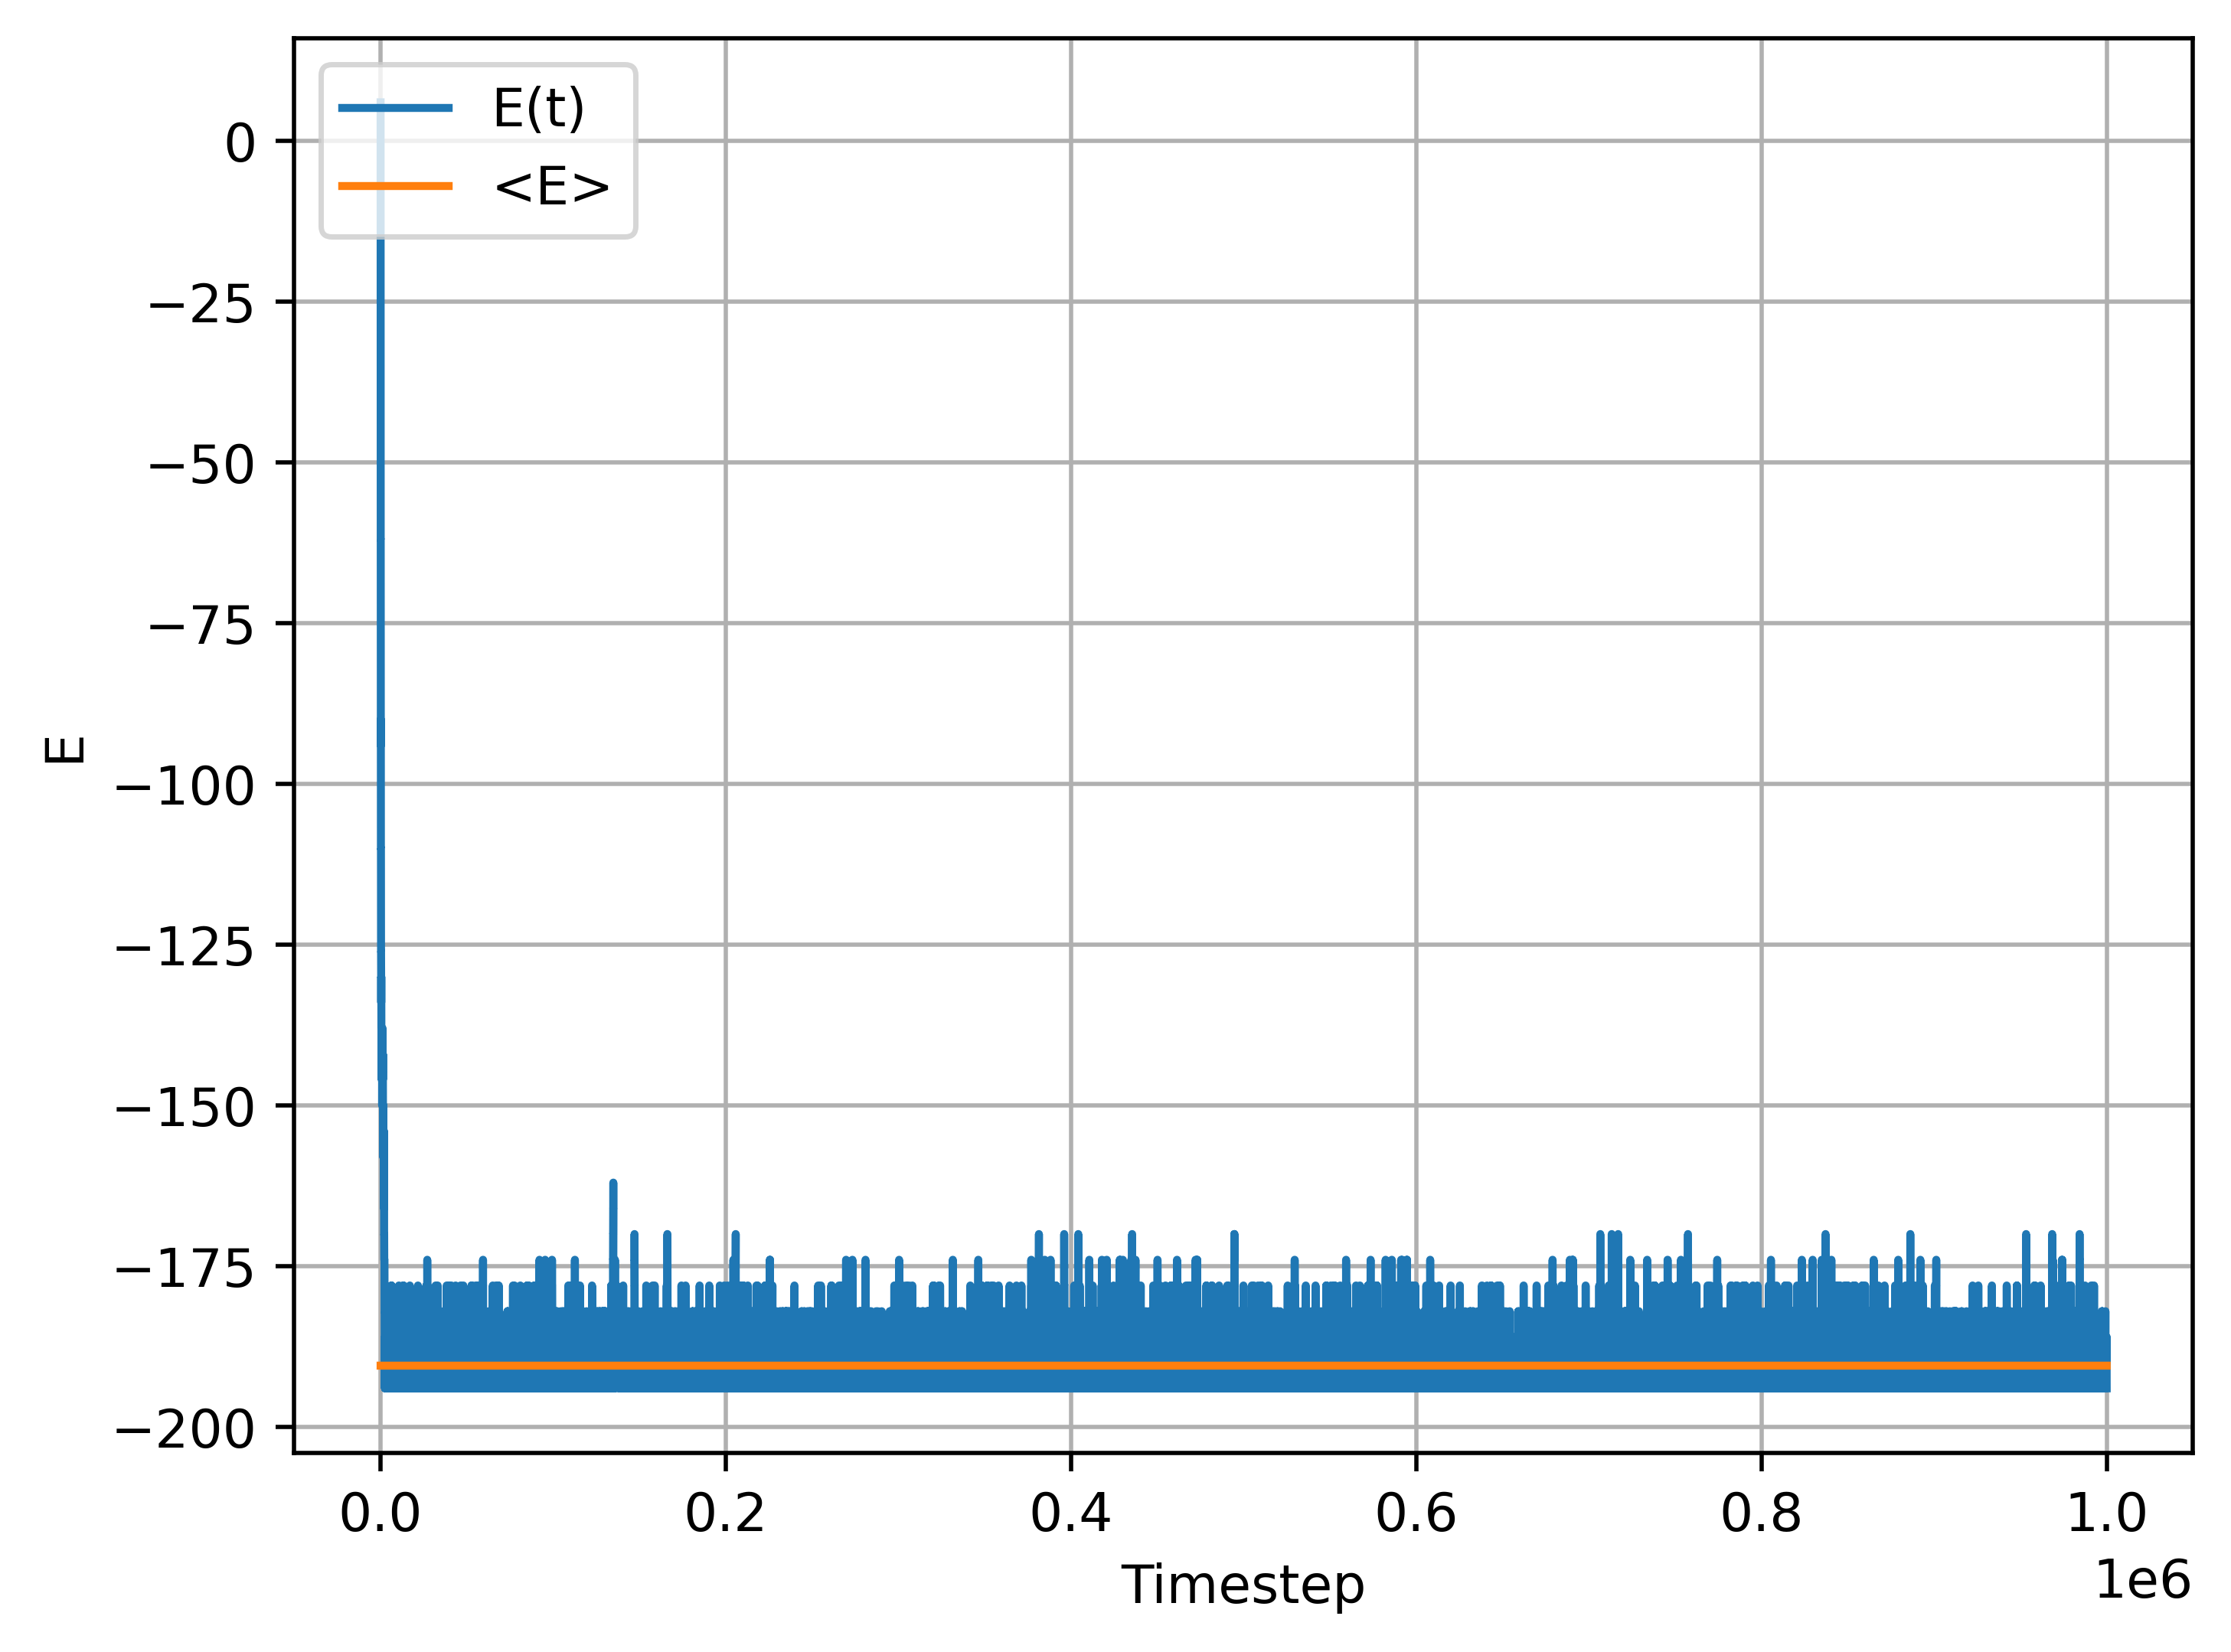

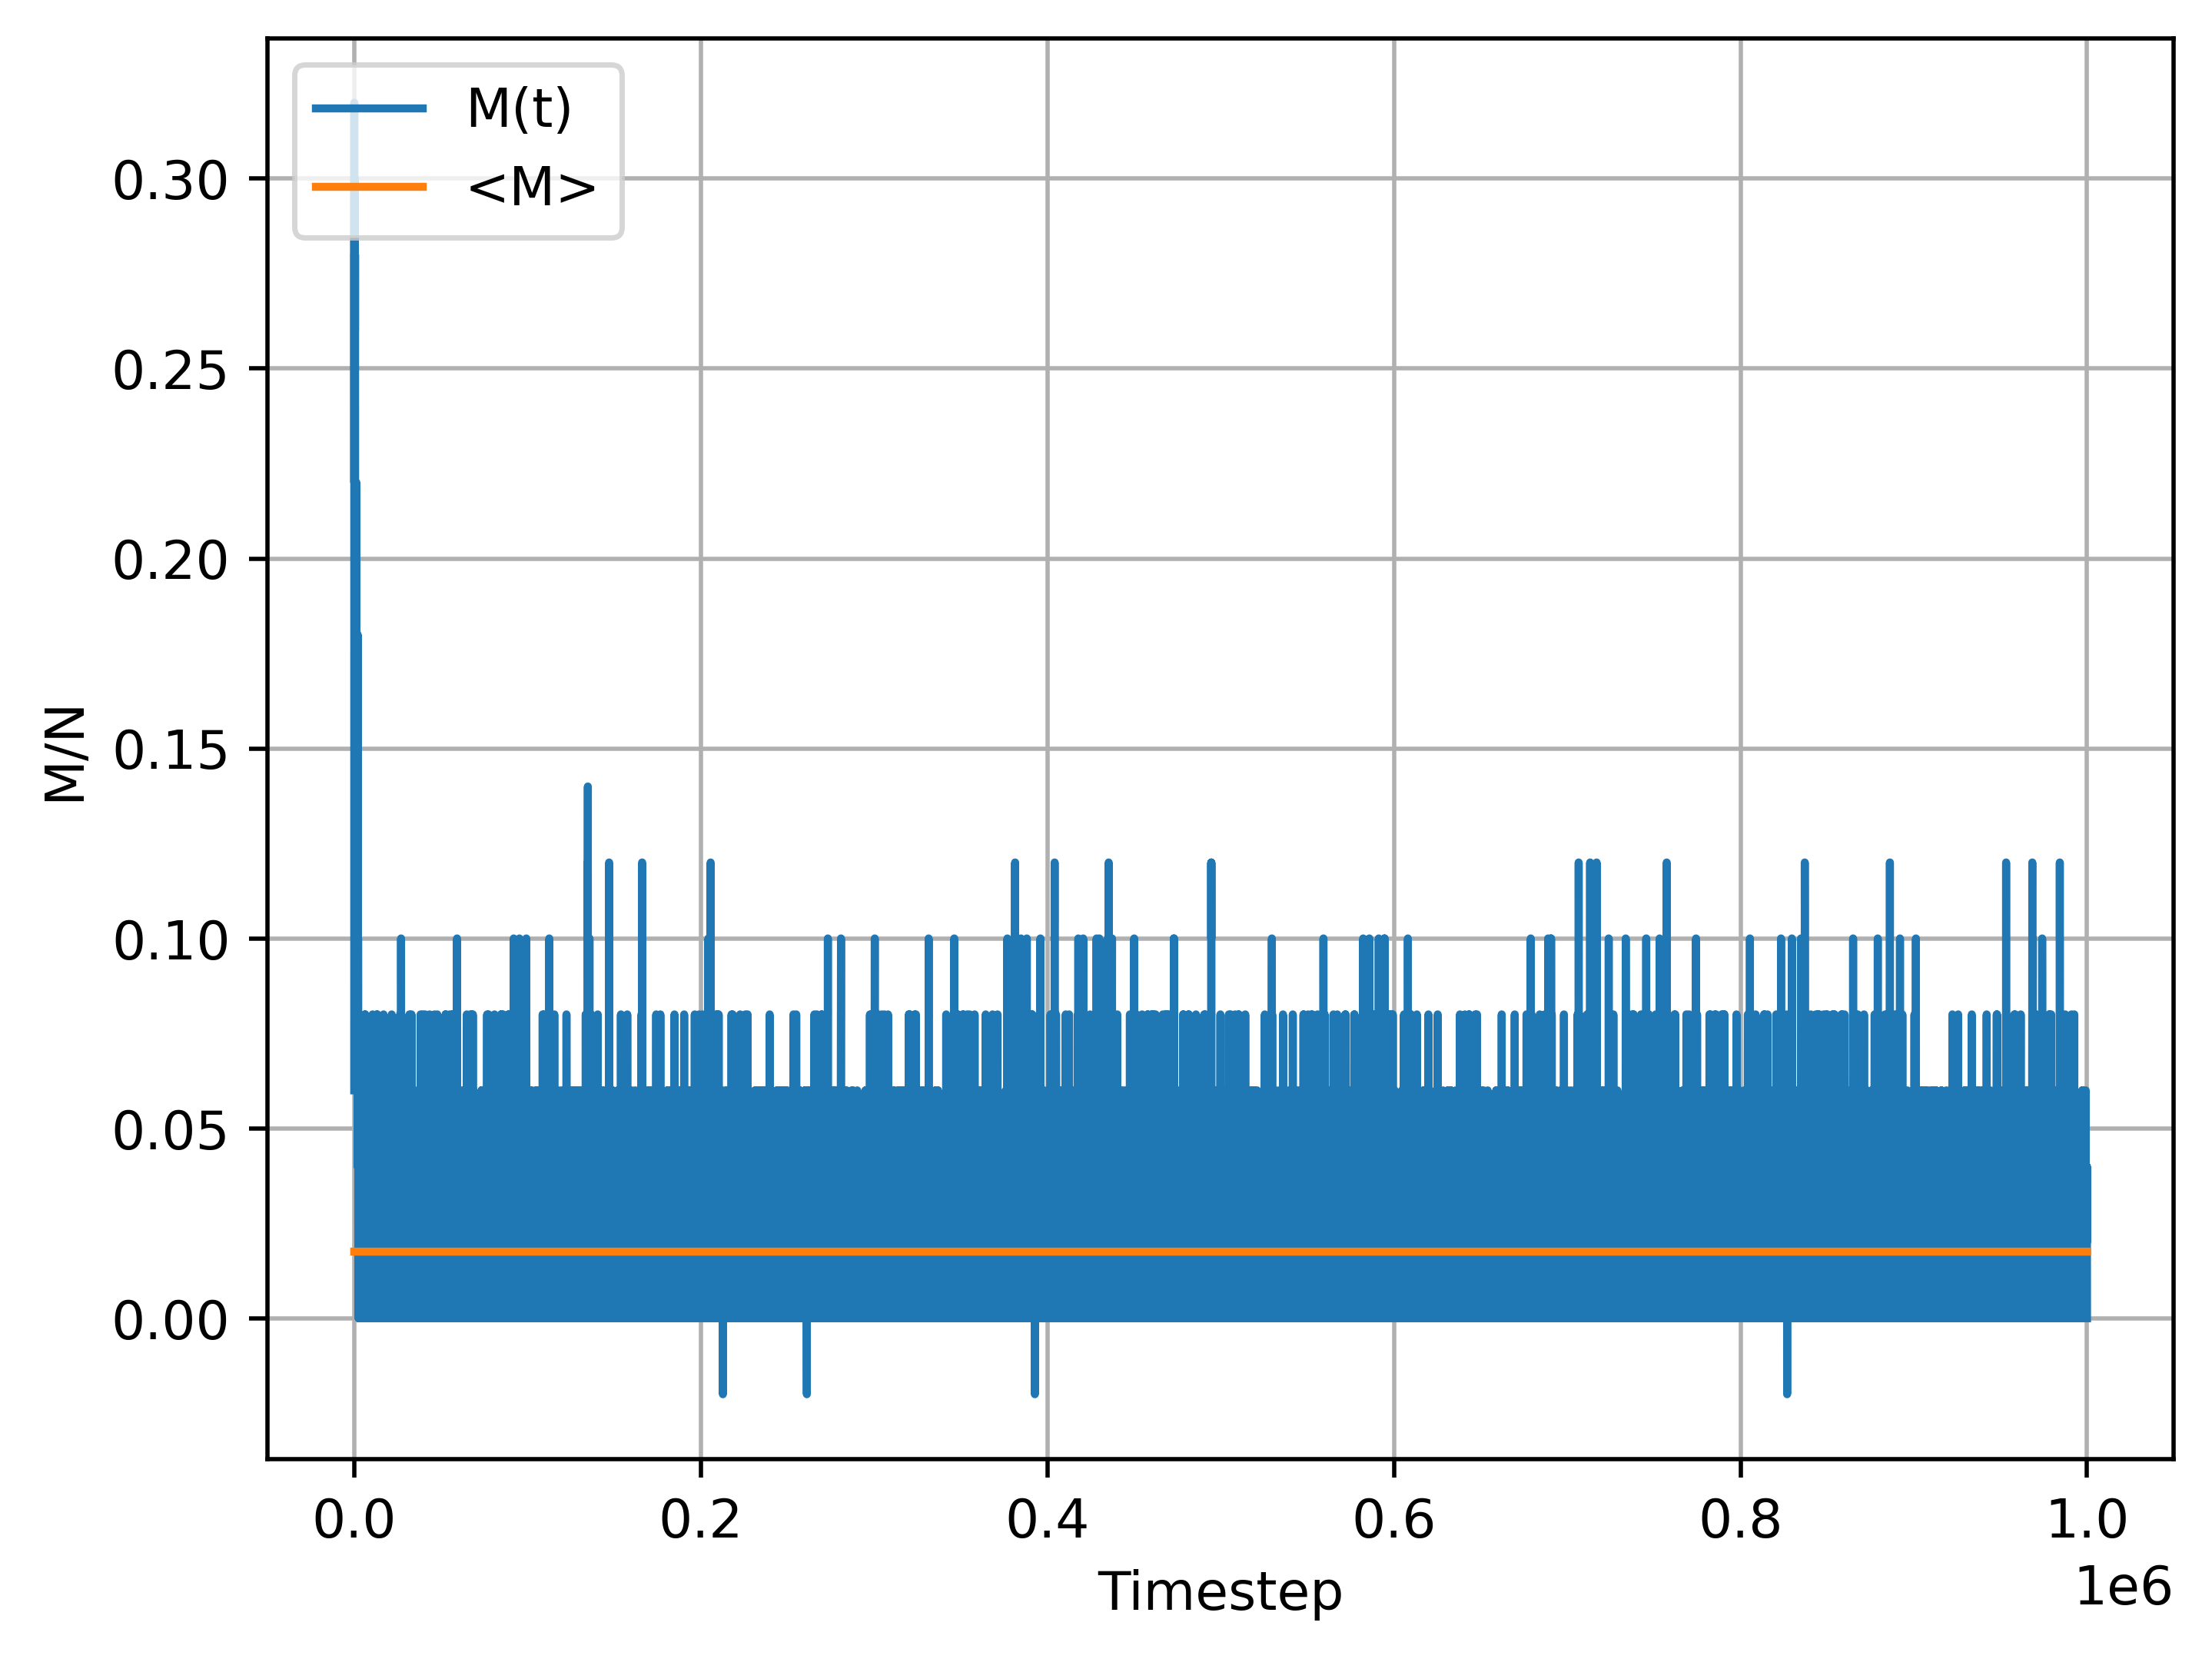

In [11]:
fig,ax = plt.subplots(1)


ax.plot(np.linspace(1,steps,steps), Earr, label='E(t)')
ax.plot(np.linspace(1,steps,steps), np.linspace(1,1,steps)*Eave, label='<E>')

handles,labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1]]
labels = [labels[0], labels[1]]

ax.legend(handles,labels,loc=2)

plt.ylabel('E')
plt.xlabel('Timestep')
plt.grid(True)
plt.show()
fig,ax = plt.subplots(1)
ax.plot(np.linspace(1,steps,steps), Marr,label='M(t)')
ax.plot(np.linspace(1,steps,steps), np.linspace(1,1,steps)*Mave, label='<M>')
handles,labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1]]
labels = [labels[0], labels[1]]

ax.legend(handles,labels,loc=2)
plt.ylabel('M/N')

plt.xlabel('Timestep')
plt.grid(True)
plt.show()

## Measure $\tau$ relaxation

The porposed method is to fit an exponential to the average magnetization. Every spin is 'up' at $t=0$.

Initialize Grid...


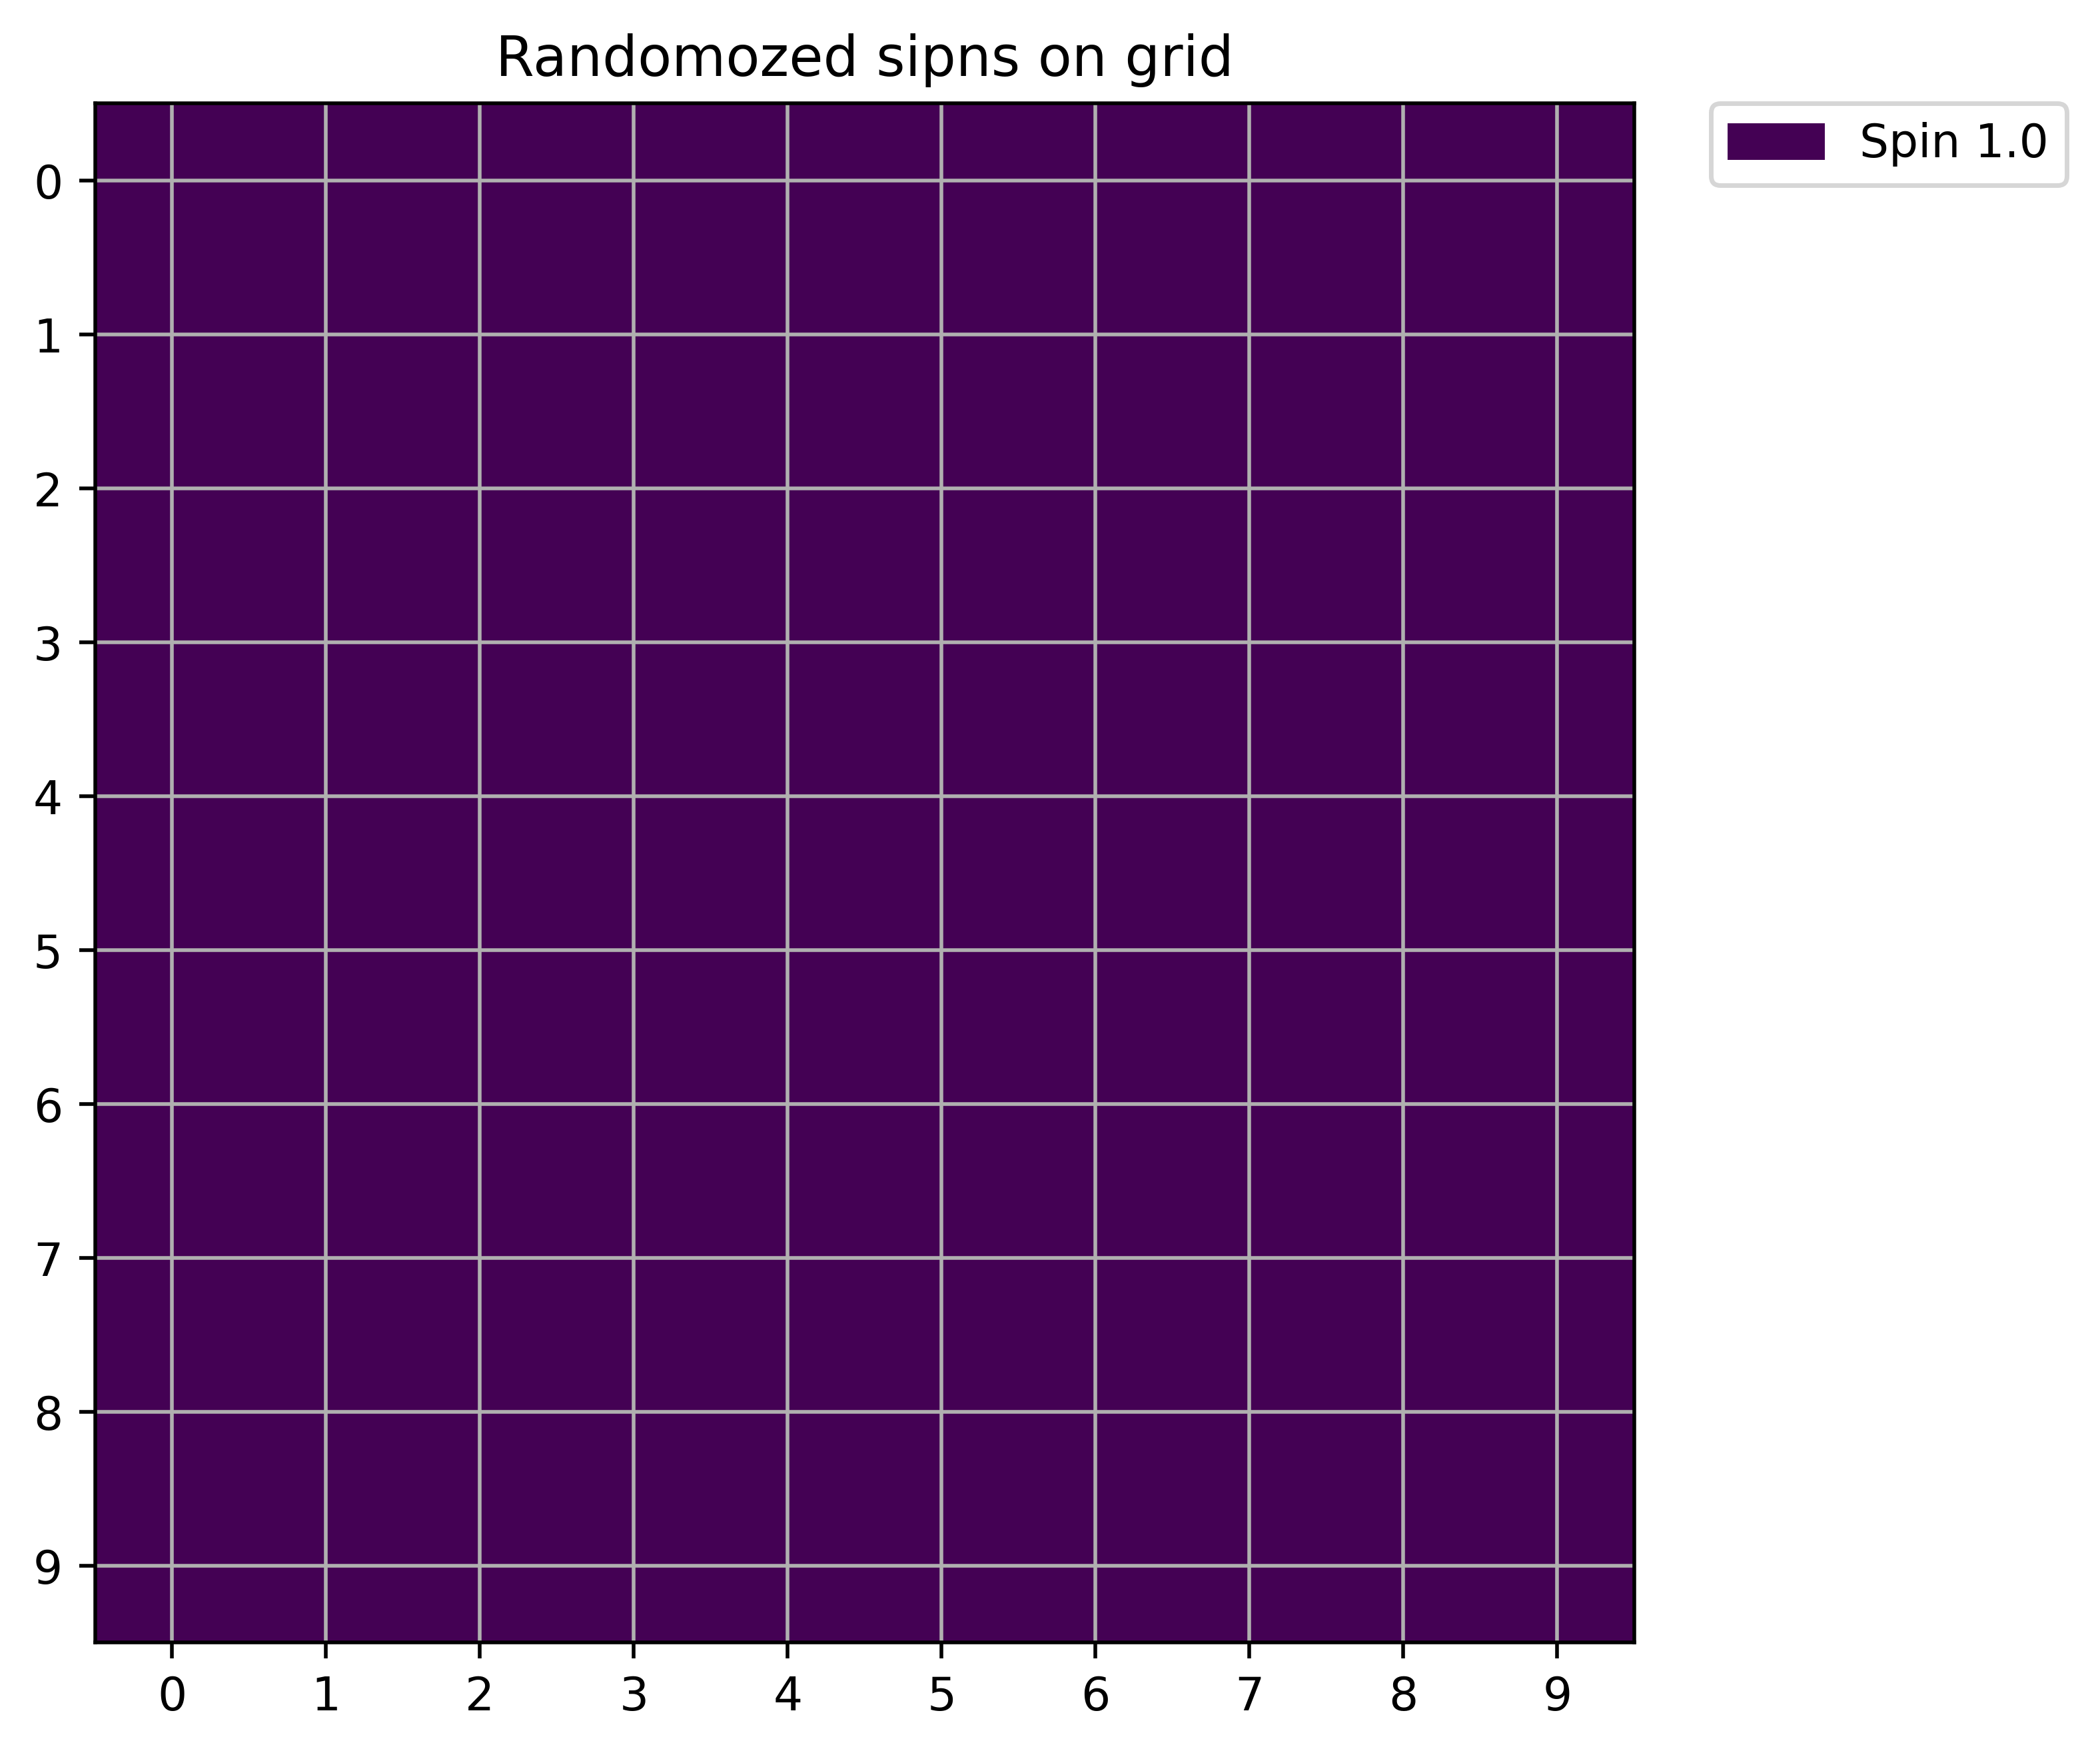

Grid initialized!


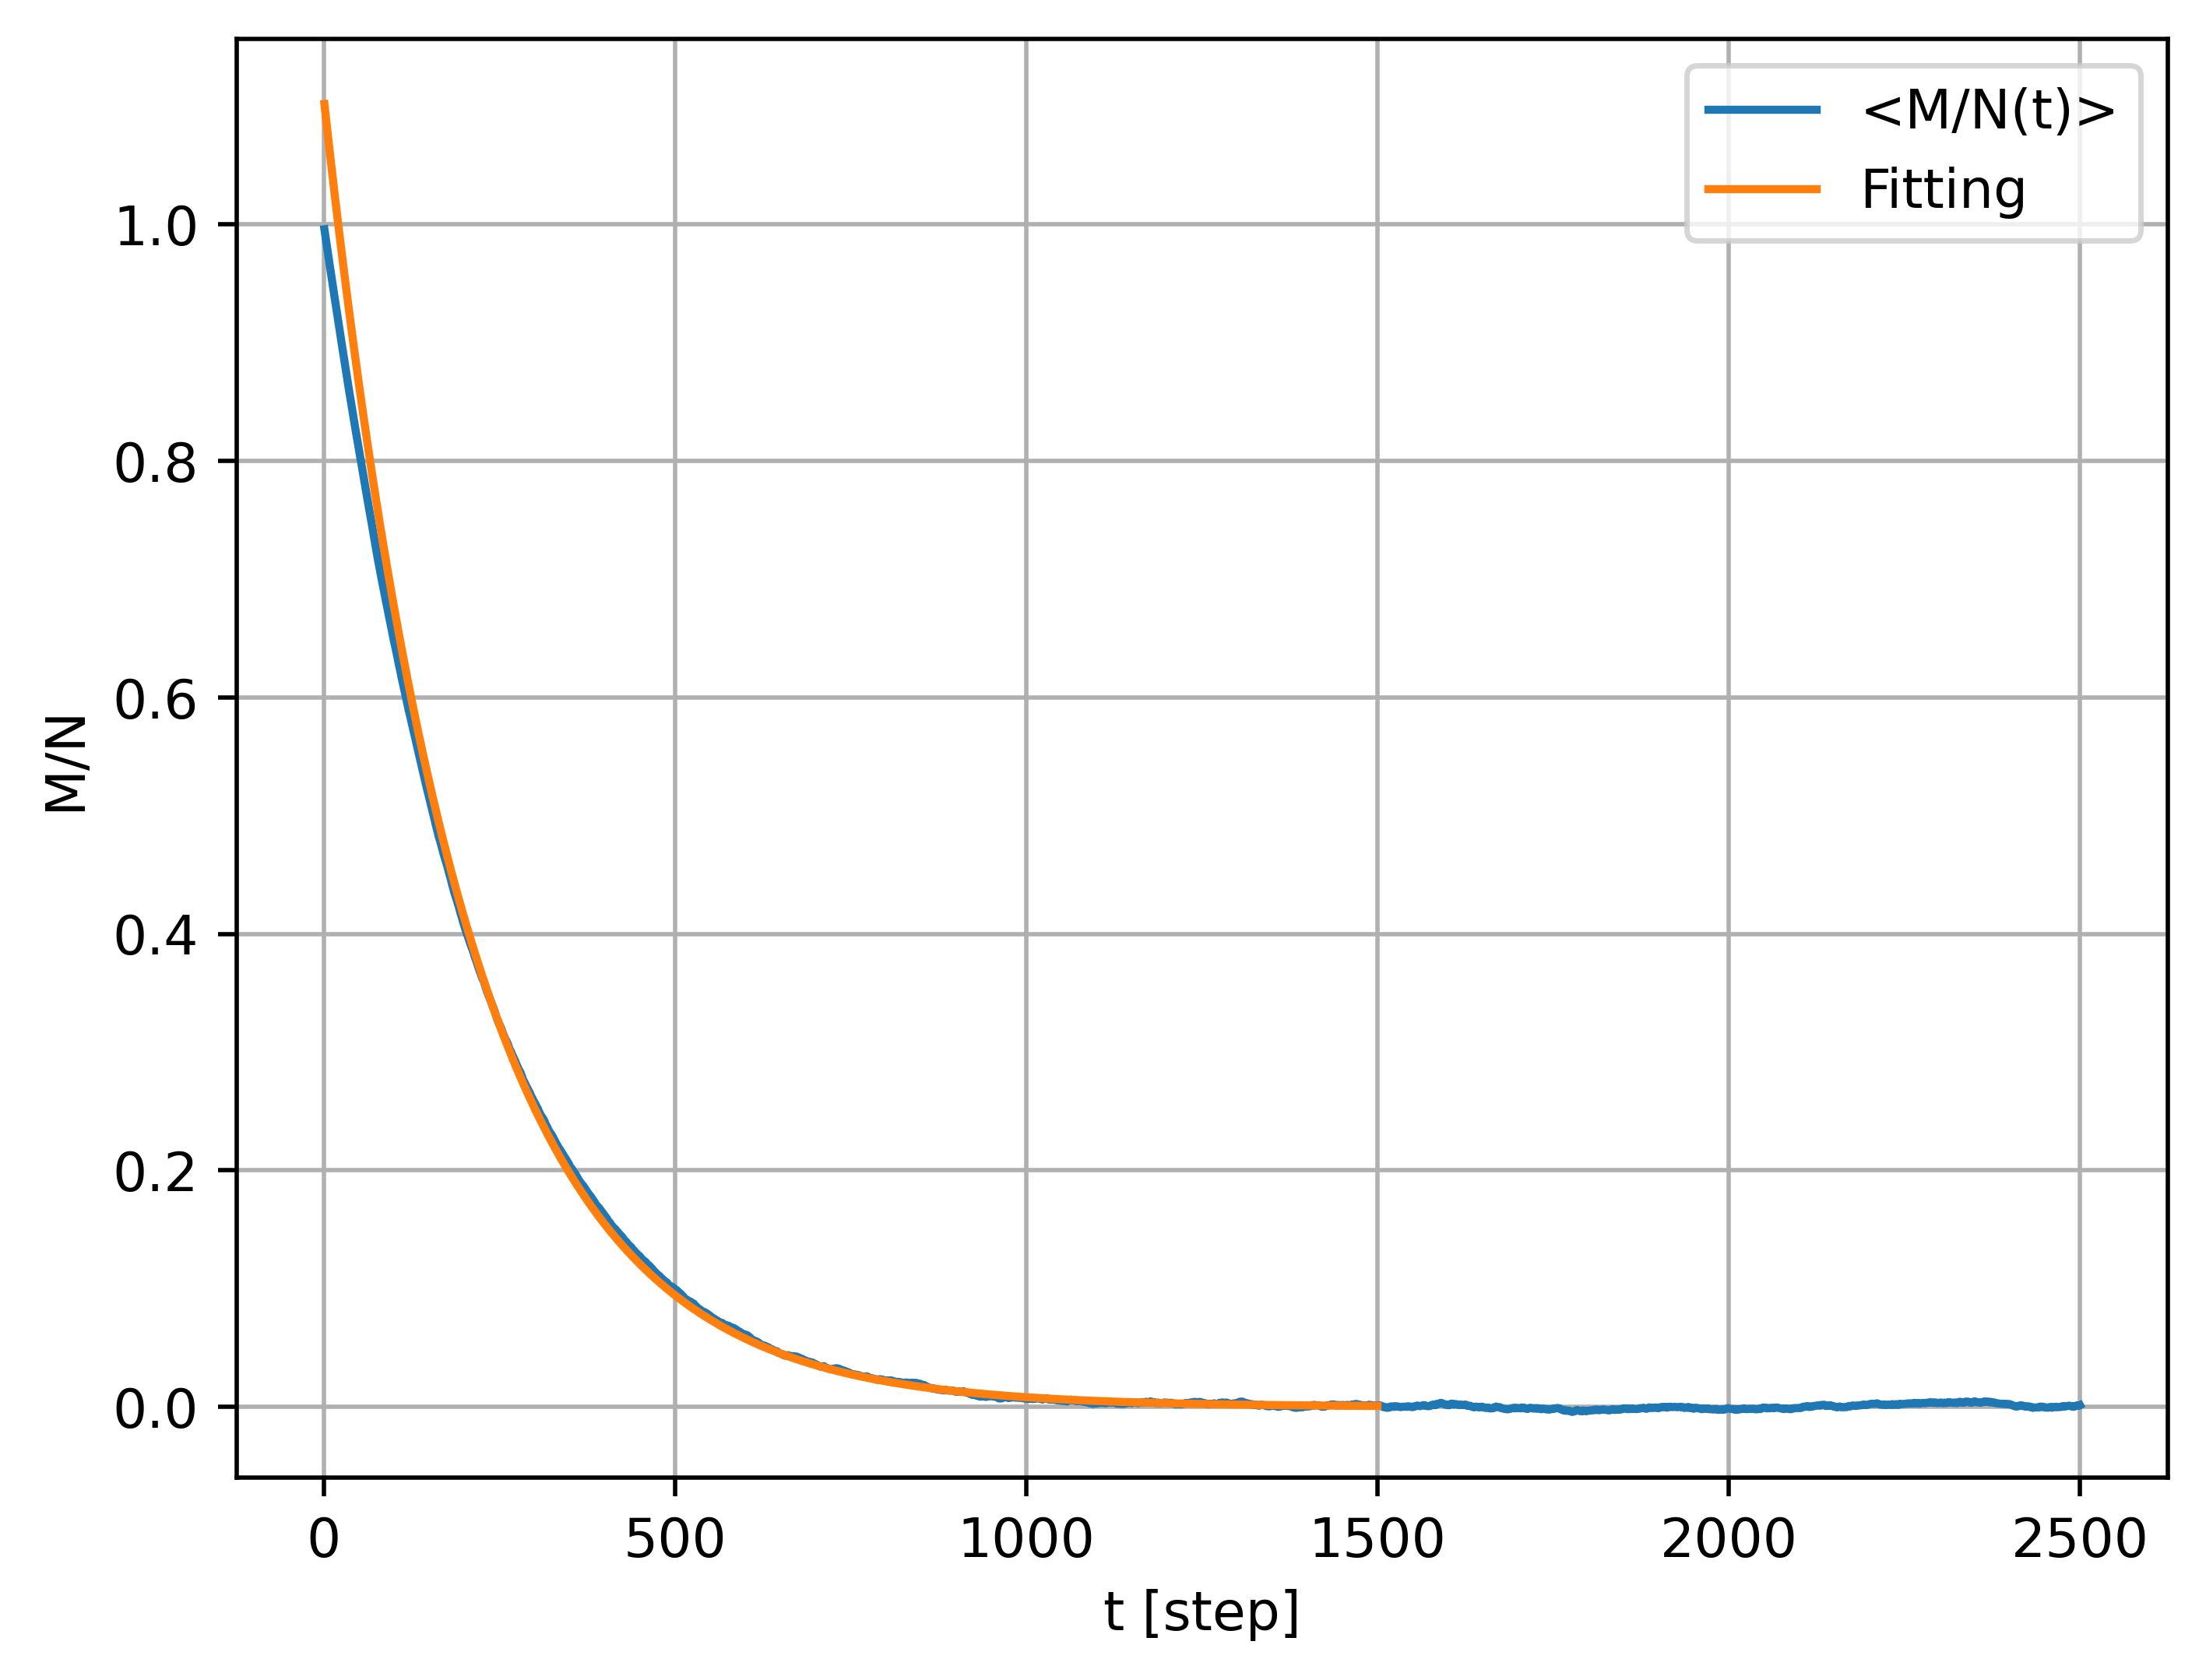

-0.00492584854540521
0.10191770727004368


In [39]:
print('Initialize Grid...')
M, L = initgrid(10,True, True)
polyarreh1=[]
polyarreh2=[]
Marrnp=np.ones(2500)
print('Grid initialized!')
for i in range (5000):
    M, L = initgrid(10,True, False)
    Earr, Eave, Spins, steps, Marr, Mave = isingmodel(2500,0,1,5,L,M)
    Marrnp=np.c_[Marrnp,Marr]
    #plotspins(Spins,2)
means=[]
for i in range(2500):
    means.append(np.mean(Marrnp[i,:]))

poly=np.polyfit(np.linspace(1,1000,1000),np.log(means[:1000]),1) #fitting for the linearized y(x) datapairs

p1=poly[0]
p2=poly[1]
fig,ax= plt.subplots(1)
ax.plot(np.linspace(1,steps,steps), means, label = '<M/N(t)>')
ax.plot(np.linspace(1,1500,1500),np.exp(p1*np.linspace(1,1500,1500)+p2), label='Fitting')
plt.ylabel('M/N')

handles,labels=ax.get_legend_handles_labels()
handles = [handles[0], handles[1]]
labels = [labels[0], labels[1]]
ax.legend(handles, labels)

plt.xlabel('t [step]')
plt.grid(True)
plt.show()
print(p1)
print(p2)
#Show parameters. 

In [27]:
np.shape(Marrnp)
Marrnp

array([[1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
       ...,
       [1.  , 0.98, 0.92, ..., 0.96, 1.  , 0.82],
       [1.  , 0.98, 0.92, ..., 0.96, 1.  , 0.82],
       [1.  , 0.98, 0.9 , ..., 0.96, 1.  , 0.82]])

## Measure varying h

In [13]:
ave1 = []
ave2 = []
ave3 = [] 
ave4 = []
ave5 = []#Array for the average magnetization for various kbT
H = []  #Array for the corresponding external field
for i in range(100):
    Grid, L = initgrid(10,True, False) #Init grid with all spins up
    h = np.random.random()*20-10 # Randomly select the external field in h=[-10, 10]
   
    Earr,Eave,Spins,steps, Marr, Mave = isingmodel(50000,h,1,2,L,Grid) #Monte Carlo simulation
    ave2.append(Mave)
    Grid, L = initgrid(10,True, False)
    Earr,Eave,Spins,steps, Marr, Mave = isingmodel(50000,h,1,3,L,Grid) #Monte Carlo simulation
    ave3.append(Mave)
    Grid, L = initgrid(10,True, False)
    Earr,Eave,Spins,steps, Marr, Mave = isingmodel(50000,h,1,4,L,Grid) #Monte Carlo simulation
    ave4.append(Mave)
    Grid, L = initgrid(10,True, False)
    Earr,Eave,Spins,steps, Marr, Mave = isingmodel(50000,h,1,5,L,Grid) #Monte Carlo simulation
    ave5.append(Mave)
    
    H.append(h) 

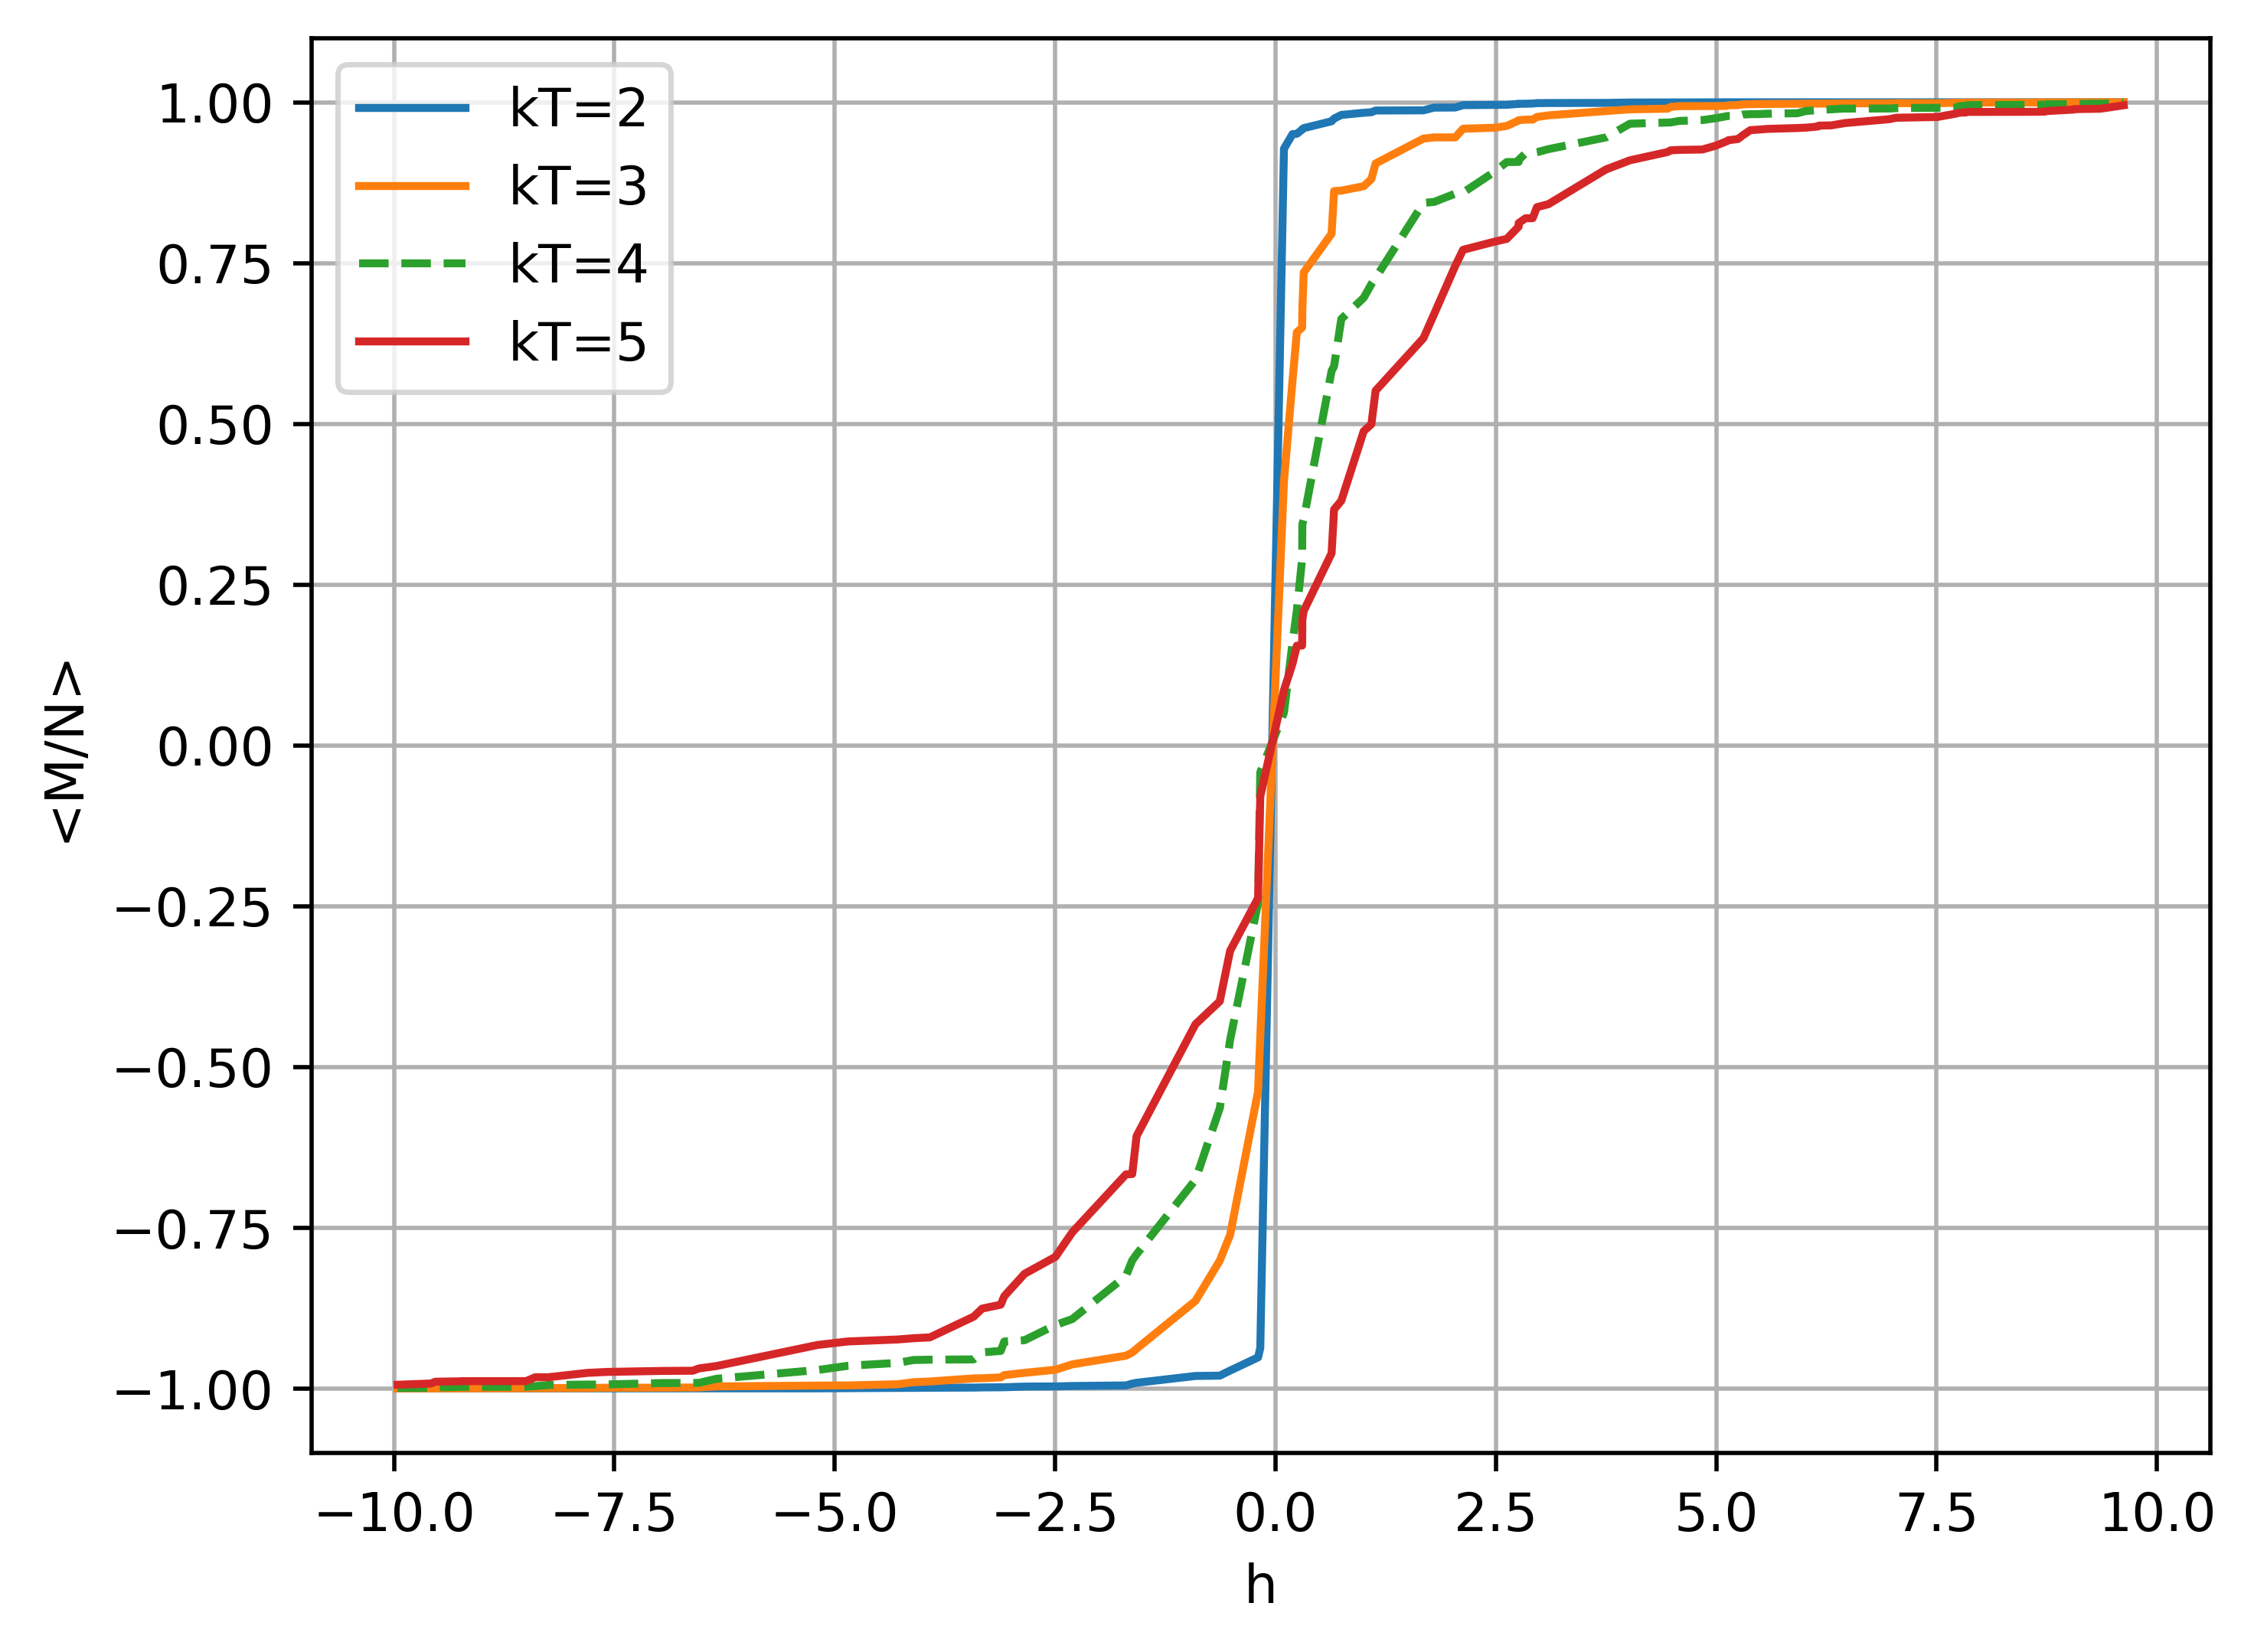

In [14]:
#Simple visualisation 

fig,ax = plt.subplots(1)

data=np.array([H,ave2])
data2=np.sort(data)
ax.plot(data2[0,:],data2[1,:],'-',label='kT=2')

data=np.array([H,ave3])
data2=np.sort(data)
ax.plot(data2[0,:],data2[1,:],'-',label='kT=3')

data=np.array([H,ave4])
data2=np.sort(data)
ax.plot(data2[0,:],data2[1,:],'--',label='kT=4')

data=np.array([H,ave5])
data2=np.sort(data)
ax.plot(data2[0,:],data2[1,:],'-',label='kT=5')

handles,labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2],labels[3],]

ax.legend(handles,labels,loc=2)

plt.xlabel('h')
plt.ylabel('<M/N>')
plt.grid(True)

# Discussion
* Large *h* means large external field, which makes the spins orient in the same direction (up), i.e. $\lim(M)_{h->{\infty}} = N$.
* With opposite *h*, the opposite orientation occurs - every spin down- (M is an odd function), and $\lim(M)_{h->{-\infty}} = -N$.
* At *h=0*, the interaction term dominates, resulting in $M=0$ (as many up spins as down).

# Susceptibility
The definition of the susceptibility is
$$ \chi = \frac{\partial M}{\partial h}$$ 
We evaluate the expression at $h=0$. I did it in two ways: using the central difference method, and simply fitting a line (slope -> derivative) for small h values. I start to discuss the latter, first: 

In [24]:
H=[] # list for small fields
ave=[] # list for average magnetization
full= [] # list for 'magnetization history'

for i in range(50):
    h=np.random.random()*0.1-0.05
    M, L = initgrid(10,True, False)
    Earr, Eave, Spin1,steps, Marr, Mave1 = isingmodel(1000000,h,1,5,L,M)
    full=full+Marr[steps-100000:] # last 1000000 moves (to calculate fluctuations later)
    ave.append(Mave1)
    H.append(h)

In [25]:
for i in range(len(ave)):
    ave[i]=ave[i]*100 # M = (M/N)*N

55.879740524645705


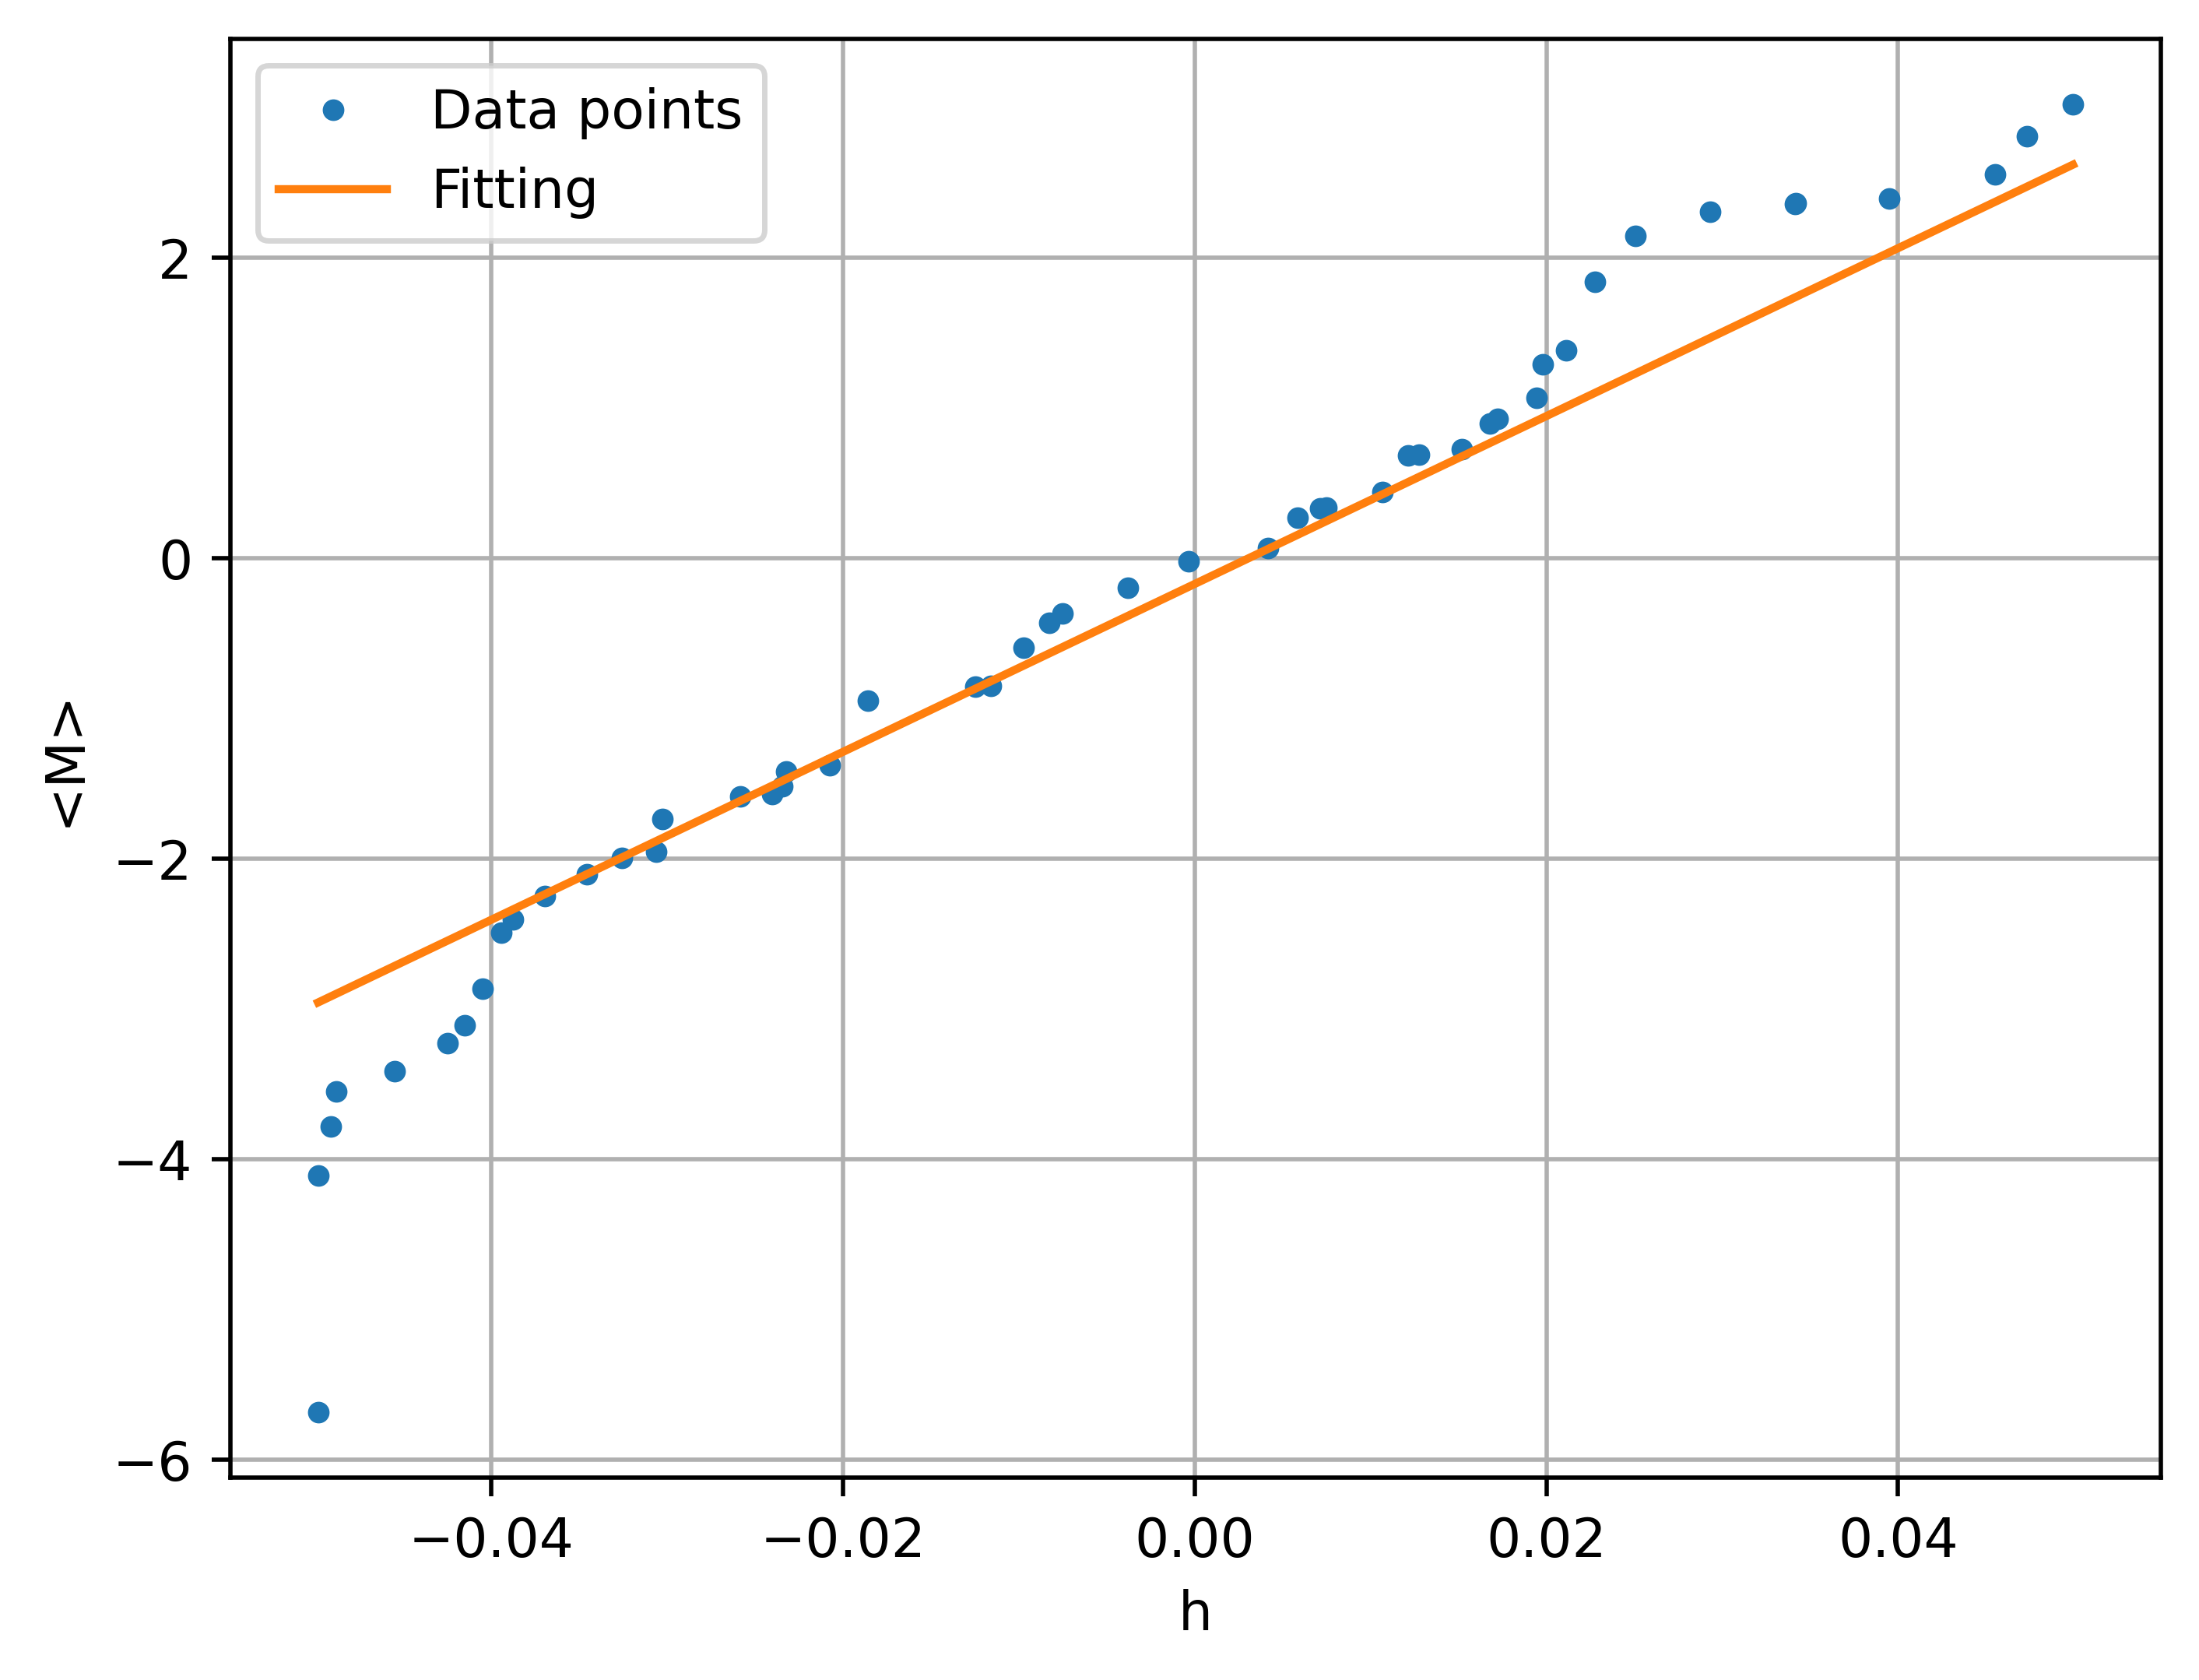

In [26]:

data=np.array([H,ave])
data2=np.sort(data)
poly=np.polyfit(H,ave,1)

fig,ax = plt.subplots(1)
ax.plot(data2[0,:],data2[1,:],'.', label = 'Data points')
ax.plot(data2[0,:], poly[0]*data2[0,:]+poly[1], label='Fitting')

handles,labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1]]
labels = [labels[0], labels[1]]

ax.legend(handles,labels,loc=2)
print(poly[0])
plt.grid(True)
plt.xlabel('h')
plt.ylabel('<M>')
plt.show()

Now lets check if

$$\chi = \left( \left< M^2\right>- \left<M\right>^2\right)\cdot \beta$$
holds. It is enough to calculate
$$Var(M)\cdot \beta$$

In [ ]:

for i in range(len(full)):
    full[i]=full[i]*10

In [28]:

std=np.std(full)
var=std*std
chi=var/5 #kbT
print(chi)

58.16195582412335


So the proposed claim __holds__

## Summary

* The Monte Carlo-Metropolis algorithm was succesfully implemented to find the equilibrium states of the given configuraitons in the 2D Ising model
* An M(h) curve was plotted, which correlates with the normalised M seen in Kertész János et. al. Statisztikus Fizika pp. 148, figure 4.8.
* The different $kbT$ values were also evaluated in the figure
* The relaxation time was estimated, however, it is inaccurate 
* We also verified the susceptibility from the fluctuations of the magnetization